# Assignment 2 - Convolutional Neural Network (CNN)

Submission DDL: 10.11.2024 23:59.

* For the tasks that require the text answer use *Insert* > *Text cell* and provide your answer in this cell. Text cell supports Markdown.
* Submit your work to the submission box on MyCourses. You should submit only the **.ipynb file** with your code.
* To download the file from Google Colab use *File* > *Download* > *Download .ipynb*.
* Submit the file with the name: A2_NAME_SURNAME_STUDENT NUMBER.ipynb

**NB! Before editing the file, save a local copy to your Google Drive, otherwise your progress will be lost.**

In this assignment, you need to train a convolutional neural network with an architecture inspired by a VGG-network [(Simonyan \& Zisserman, 2015)](https://arxiv.org/abs/1409.1556). VGG is a deeper neural network than that we demonstrated in the tutorial session.

Before starting the assignment make sure, that GPU acceleration is activated on Google Colab to benefit from lower computational times. Go to *Runtime* > *Change runtime type* and select *T4 GPU*. On Azure the GPU is always active. It it recommended to make sure that the code works and training of the model starts on Google Colab, before running it on Azure.

The assignment contains 3 main tasks:
* **A** – create the class to represent VGG network **(8 points)**
* **B** – train the network **(6 points)**
* **C** – evaluate the performance of the network **(6 points)**

Further description and specific instructions are provided within the course of the assignment. Places where you need to write your code are commented with capital leters, e.g. #YOUR CODE HERE

The figure below illustrates a high-level view of the machine learning process we aim to establish in this notebook:

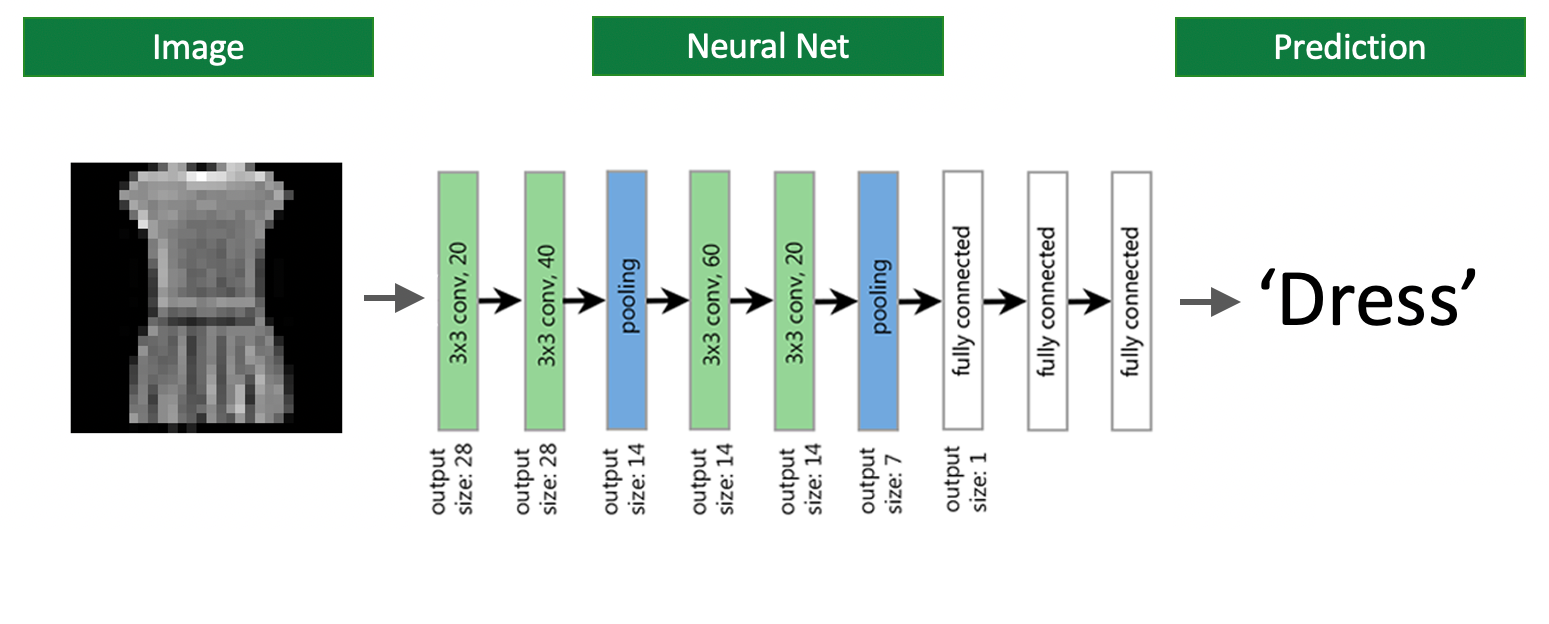

You can learn more about this dataset at:
* [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)

## 1. Assignment objectives

After this assignment, you should be able to:

> 1. Learn how to use and implement the **VGG19** for image classification.
> 2. Understand the effect of increasing convolutional layers.
> 3. Understand why we add zero padding to input images.
> 4. Know how to **interpret the networks classification results** and **confusion matrix**.


## 2. Setup of the Jupyter Notebook Environment

At first, we need to import a couple of Python libraries that allow for data analysis and data visualization.

In [67]:
import os
import time
import sys
import getpass

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import random

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Depending on the platform, we create the necessary directories and download the dataset and store the networks.
- On Google Colab our working directory is placed on the Google Drive, so we need to mount it. The directory is `/content/drive/MyDrive/Colab Notebooks/dsfb2/a2`
- On Azure and personal Windows machines the directory is `C:/Users/$USER/dsfb2/a2`, `$USER` is the username. On Azure it is predefined, on personal Windows machines it is your username.
- On MacOS the directory is `/Users/$USER/Documents/dsfb2/a2`, where `$USER` is your username.

In [102]:
# check if running on Google Colab
if 'google.colab' in str(get_ipython()):

    print('Running on Colab')

    # import the Google Colab GDrive connector
    from google.colab import drive

    # mount GDrive inside the Colab notebook
    !rm -r /content/drive/*

    drive.mount('/content/drive')

    # name Colab Notebooks directory
    notebook_directory = '/content/drive/MyDrive/Colab Notebooks/dsfb2/a2'

    # name data directory
    data_directory = '/content/drive/MyDrive/Colab Notebooks/dsfb2/a2/data_fmnist'

    # name models directory
    models_directory = '/content/drive/MyDrive/Colab Notebooks/dsfb2/a2/models_fmnist'
else:
    # check if running on MacOS
    if sys.platform == 'darwin':
        print('Running on MacOS')

        # get the username
        user_name = getpass.getuser()

        # name main directory
        notebook_directory = f"/Users/{user_name}/dsfb2/a2"

        # name data directory
        data_directory = f"/Users/{user_name}/dsfb2/a2/data_fmnist"

        # name models directory
        models_directory = f"/Users/{user_name}/dsfb2/a2/models_fmnist"

    # check if running on Windows
    elif sys.platform == 'win32':
        print('Running on Windows')

        # get the username
        user_name = getpass.getuser()

        # name main directory
        notebook_directory = f"C:/Users/{user_name}/dsfb2/a2"

        # name data directory
        data_directory = f"C:/Users/{user_name}/dsfb2/a2/data_fmnist"

        # name models directory
        models_directory = f"C:/Users/{user_name}/dsfb2/a2/models_fmnist"


# create the main directory
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

# create data sub-directory inside the main directory
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
if not os.path.exists(models_directory): os.makedirs(models_directory)

Running on Colab
Mounted at /content/drive


Set a random `seed` value to obtain reproducable results:

In [69]:
# init deterministic seed

seed_value = 863522 # YOUR CODE HERE # INPUT YOUR STUDENT NUMBER HERE, omit the letters
assert type(seed_value) is int, "Exclude letters, leave only numbers"


np.random.seed(seed_value) # set numpy seed

Enable GPU computing by setting the device flag and init a CUDA and MPS seed. CUDA is used for Nvidia GPUs and MPS is used for Apple MacBooks with Apple Silicon.

In [70]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

# init deterministic GPU and CPU seed
torch.manual_seed(seed_value) # set pytorch seed

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by e.g. `Google's Colab` environment:

In [71]:
if device == 'cuda':
    !nvidia-smi
elif device == 'mps':
    print('Using Apple M-series SoC GPU accelerator')
else:
    print('Using CPU')

Using CPU


## 3. FashionMNIST database

Let's download, transform and inspect the training images of the dataset. Therefore, let's first define the directory in which we aim to store the training data:

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

# download the dataset
trainset = torchvision.datasets.FashionMNIST(root=data_directory, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_directory, train=False, download=True, transform=transform)

# validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# define the labels of the images
classes = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# specify the batch size for training and test
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

In [73]:
# determine the number of training data images
len(trainset)

48000

In [74]:
# determine the number of test data images
len(testset)

10000

Great, let's now visually inspect our sample image:

In [75]:
# define a function for plot
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

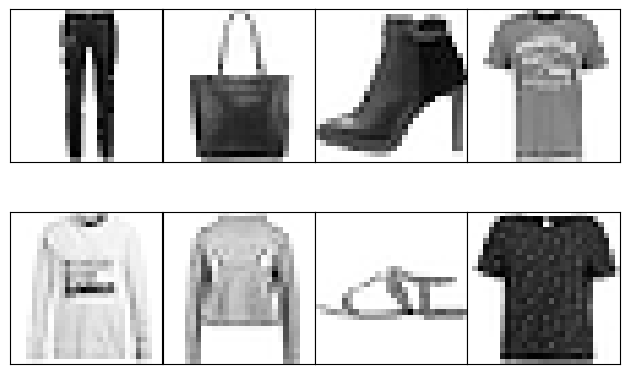

In [76]:
images, labels = next(iter(trainloader))
plot_images(images[:8], n_rows=2)

## 4. Neural Network Implementation

**TASK A** – implement VGG network **(8 points)**
---
Now, you will implement the architecture of the **VGG19**. You aim to learn a model that is capable of classifying the 28x28 pixel FashionMNIST images according to the objects contained in each image.

The architecture:
- One convolutional layer with:
    - 3x3 kernel
    - 20 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 3x3 kernel
    - 40 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- One convolutional layer with:
    - 3x3 kernel
    - 60 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 3x3 kernel
    - 20 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- A block of three linear layers with ReLU nonlinearity with:
    - linear layers with 20x7x7 inputs and 100 outputs
    - ReLU nonlinearity
    - linear layers with 100 inputs and 50 outputs
    - ReLU nonlinearity
    - linear layers with 50 inputs and 10 outputs

Notes:
* Batch normalization is expected to be right after a convolutional layer, before nonlinearity.
* We recommend that you check the number of modules with trainable parameters in your network.

In [77]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()


        self.convolutional_layer = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(1, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),

            # convolutional layer 2
            nn.Conv2d(20, 40, kernel_size=3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),

            # pooling layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 3
            nn.Conv2d(40, 60, kernel_size=3, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(),

            # convolutional layer 4
            nn.Conv2d(60, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),

            # pooling layer 2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # fully connected layers
        self.linear_layer = nn.Sequential(
            nn.Linear(20*7*7, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
          verbose: True if you want to print the shapes of the intermediate variables.

        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        x = self.convolutional_layer(x)
        x = x.view(-1, 20*7*7)
        x = self.linear_layer(x)
        return x

In [78]:
def test_VGGNet_shapes():
    net = VGGNet()
    net.to(device)

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), f"Bad y.shape: {y.shape}"

    print('Success, shapes are correct :)')

test_VGGNet_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
Success, shapes are correct :)


In [79]:
# Initiate the network
net = VGGNet()# YOUR CODE HERE

In [80]:
# Send the network to to your computational device
# YOUR CODE HERE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)


cpu


In [81]:
# Check that that Google Colab GPU received the network (memory usage has changed)
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 5. Neural Network Model Training

**TASK B** – train VGG network **(6 points)**
---


Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.01.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10

We recommend you to use function `compute_accuracy()` defined below to track the accaracy during training. The test accuracy should be above 0.9.

**Note: function `compute_accuracy()` sets the network into the evaluation mode which changes the way the batch statistics are computed in batch normalization. You need to set the network into the training mode (by calling `net.train()`) when you want to perform training.**

In [82]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

Below is the training loop. When you make sure it works properly, you can move to Azure to train the network on a GPU and evaluate its performance.

In [83]:
# define the optimization criterion / loss function
ce_loss = nn.CrossEntropyLoss() # YOUR CODE HERE

# define learning rate and optimization strategy
learning_rate = 0.01 # YOUR CODE HERE
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # YOUR CODE HERE

# init collection of training epoch losses
train_losses = []

# set the model in training mode
net.train() # YOUR CODE HERE

# set the number of epochs
epochs = 10 # YOUR CODE HERE

# Implement the training loop
for epoch in range(epochs):

    # init the time
    time0 = time.time()

    # init collection of mini-batch losses
    running_loss=[]

    # iterate over all-mini batches
    for batch_idx, data in enumerate(trainloader,0):

        # push mini-batch data to computation device
        # YOUR CODE HERE
        inputs, labels = data[0].to(device), data[1].to(device)

        # run forward pass through the network
        # YOUR CODE HERE
        outputs = net(inputs)

        # reset graph gradients
        # YOUR CODE HERE
        optimizer.zero_grad()

        # determine classification loss
        # YOUR CODE HERE
        loss = ce_loss(outputs, labels)

        # run backward pass
        # YOUR CODE HERE
        loss.backward()

        # update network paramaters
        # YOUR CODE HERE
        optimizer.step()

        # collect mini-batch reconstruction loss
       # YOUR CODE HERE
        running_loss.append(loss.item())

    # determine mean min-batch loss of epoch
    train_loss = np.mean(running_loss) # YOUR CODE HERE
    train_losses.append(train_loss)

    # print epoch loss
    if epoch % 1 == 0:
        print(
            f"epoch:{epoch+1}",
            "\ttrain_loss:",
            round(train_loss, 3),
            "\tvalidation_accuracy:" ,
            round(compute_accuracy(net, valloader), 3),
            "\ttest_accuracy:",
            round(compute_accuracy(net, testloader),3),
            "\tUsed_time:",
                round((time.time()-time0)/60,3)
        )


    if train_loss < 0.2:
      break
# condition for early stop to reduce overfitting, you can try using it and compare the evaluation accuracy between different numbers of epochs

KeyboardInterrupt: 

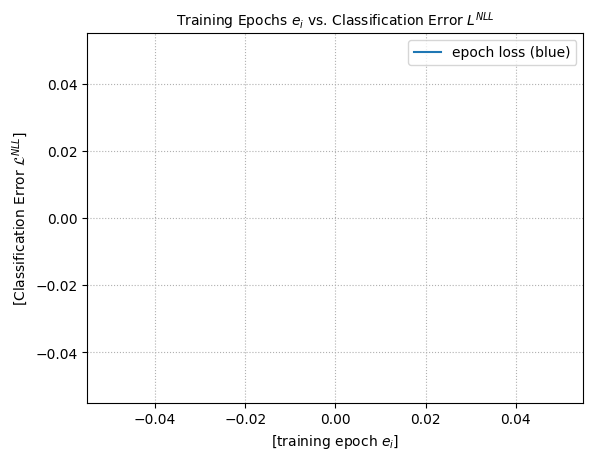

In [94]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_losses)+1)), train_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

## 6. Neural Network Model Evaluation

**Task C1** - evaluate the performance of the neural network **(2 points)**
--

In [ ]:
# save the trained model
model_name = '2_vgg_net.pth'
torch.save(net.state_dict(), os.path.join(models_directory, model_name))

In [103]:
# initialize the model
model = VGGNet() # YOUR CODE HERE

In [104]:
# load pre-trained models
model_name = '2_vgg_net.pth'
model.load_state_dict(torch.load(os.path.join(models_directory, model_name), map_location=torch.device('cpu')))

<ipython-input-104-fdc11f6ce7e6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(models_directory, model_name), map_location=t

<All keys matched successfully>

In [105]:
# set model in evaluation mode
# YOUR CODE HERE
model.eval()

VGGNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(60, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=98

In [106]:
# set (random) image id
image_id = random.randint(0, len(testset) - 1) # YOUR CODE HERE

# retrieve image exhibiting the image id
eval_image, eval_label = testset[image_id]

In [107]:
# the true label of the image
classes[eval_label]

'Coat'

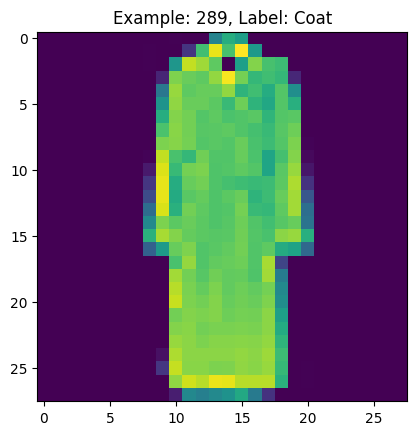

In [108]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), str(classes[eval_label])))

# un-normalize Fashion image sample
# eval_image likely has pixel values normalized to the range -1 to 1.
eval_image_plot = eval_image / 2.0 + 0.5

# plot Fashion-MNIST image sample
plt.imshow(trans(eval_image_plot))

In [109]:
# predict the label of the random image
most_probable = torch.max(model(eval_image.unsqueeze(0)).data, 1)[1].item() # YOUR CODE HERE
#torch.max(..., 1):
#Here, 1 specifies that the maximum should be found along the first dimension
print('Most probable class: {}'.format(most_probable))
print('This class represents the following fashion article: {}'.format(classes[most_probable]))

Most probable class: 4
This class represents the following fashion article: Coat


In [110]:
# store the predicted classes on the test set
predictions = []
# Inference is the process of using a trained machine learning model to make predictions on new, unseen data
# torch.no_grad() is a context manager that temporarily disables gradient calculation
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [111]:
# Compute the accuracy on the test set
# testset.targets - true labels
accuracy = metrics.accuracy_score(testset.targets, predictions)# YOUR CODE HERE
print(f'Accuracy of the VGGNet on the test images: {accuracy: .3f}')

Accuracy of the VGGNet on the test images:  0.911


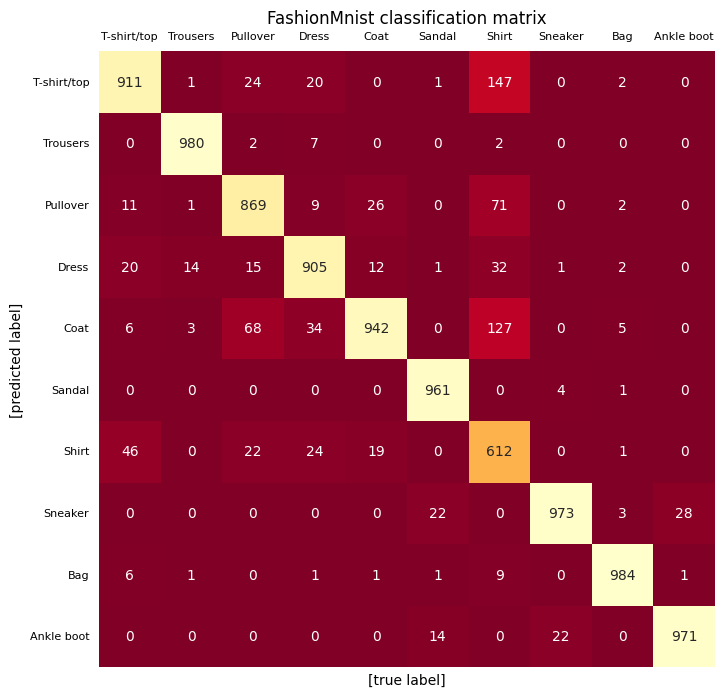

In [112]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(testset.targets, predictions) # YOUR CODE HERE

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=classes, yticklabels=classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('FashionMnist classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]')

plt.show()

## 7. Assignment Summary:

**Task C2** - discuss the implementation of the neural network **(4 points)**
--
Discuss the following:
- What are the effects of a deeper neural network?
- What are the effects of padding?
- Why do we use the max pooling layer?
- The rationale behind your choices of hyperparameters.
- A detailed analysis on the evaluation results.

You can copy the file with the code and the saved `.pth` file to Google Colab to write the summary report, so you do not spend Azure hours on writing the report.

(Your answer here)

Deeper neural networks have more layers and parameters, allowing them to learn more complex patterns in the data and hierarchical features. It can lead to better performance, especially when dealing with large and complex datasets. They are more complex to train and usually require more data and comupational resources. Besides, they are more prone to overfitting, where the model leanrs the training data too well.


Padding helps to retain information at the edges of the image, to control the spatial dimensions of the output feature maps, allowing for deeper networks.

Max pooling layer helps to downsample the feature maps by taking the maximum value in each pooling window, which reduces the number of parameters and computations. It makes the network more robust to small variations and can help to prevent overfitting.

Learning rate of 0.01 is a common starting point for the Adam optimier, which adapts the learning rate for each parameter during training.

When learning rate of 0.05 is used, a sudden drop in accuracy and a spike in training loss after epoch 3 is observed. This behavior strongly suggests that your learning rate of 0.05 is too high and the model is diverging instead of converging.

When learning rate of 0.005 is used, the training loss is stuck at 2.303 and both validation accuracy and test accuracy are extremely low, which suggests that the optimizer might be stuck in a local minimal of the loss function.

After splitting training set to 80% training data and 20% validation data, accuracy scores for both training and validation were computed in each epoch. When epoch is set to be 2, the accuracy drops to 0.659. When epoch is 10, accuracy is 0.911.

The accuracy 0.911 suggests that the model is performing reasonaly well and it correctly classify a majority of the images in the test set. However, the confusion matrix suggested that prediction on Shirt and Pullover images have been more challenging.

The evaluation result suggests more focus on images of Pullover, T-shirt/top and Shirt. More data of these categories can help the model learn better.
